In [1]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%autosave 100

Mounted at /content/drive/


Autosaving every 100 seconds


In [0]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image

In [3]:
quizes = np.empty((1000000, 81), np.float32)
solutions = np.empty((1000000, 81), np.int64)

i=0
f = open("/content/drive/My Drive/Colab Notebooks/sudoku.csv")
for line in f:
    quiz, solution = line.strip().split(",")
    quizes[i] = [int(i) for i in quiz]
    solutions[i] = [int(i) for i in solution]
    i += 1
    if i % 10000 == 0:
        print("loaded", i//10000, "%")

quizes = quizes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))

print("quizes\n", quizes[0])
print("solutions\n", solutions[0])

loaded 1 %
loaded 2 %
loaded 3 %
loaded 4 %
loaded 5 %
loaded 6 %
loaded 7 %
loaded 8 %
loaded 9 %
loaded 10 %
loaded 11 %
loaded 12 %
loaded 13 %
loaded 14 %
loaded 15 %
loaded 16 %
loaded 17 %
loaded 18 %
loaded 19 %
loaded 20 %
loaded 21 %
loaded 22 %
loaded 23 %
loaded 24 %
loaded 25 %
loaded 26 %
loaded 27 %
loaded 28 %
loaded 29 %
loaded 30 %
loaded 31 %
loaded 32 %
loaded 33 %
loaded 34 %
loaded 35 %
loaded 36 %
loaded 37 %
loaded 38 %
loaded 39 %
loaded 40 %
loaded 41 %
loaded 42 %
loaded 43 %
loaded 44 %
loaded 45 %
loaded 46 %
loaded 47 %
loaded 48 %
loaded 49 %
loaded 50 %
loaded 51 %
loaded 52 %
loaded 53 %
loaded 54 %
loaded 55 %
loaded 56 %
loaded 57 %
loaded 58 %
loaded 59 %
loaded 60 %
loaded 61 %
loaded 62 %
loaded 63 %
loaded 64 %
loaded 65 %
loaded 66 %
loaded 67 %
loaded 68 %
loaded 69 %
loaded 70 %
loaded 71 %
loaded 72 %
loaded 73 %
loaded 74 %
loaded 75 %
loaded 76 %
loaded 77 %
loaded 78 %
loaded 79 %
loaded 80 %
loaded 81 %
loaded 82 %
loaded 83 %
loaded 84 %
l

In [0]:
class ConvNet(nn.Module):
  def __init__(self, c_in, c_out, filt=3, stride=1, padding=1):
    super(ConvNet, self).__init__()

    self.conv = nn.Conv2d(c_in, c_out, (filt, filt), stride=stride, padding=padding)
    self.bn = nn.BatchNorm2d(c_out)
  
  def forward(self, x):
    n, c, h, w = x.shape
    z = F.relu(self.bn(self.conv(x)))
    return z

# n1 - number of conv layers with kernel size (3, 3) - try to learn local
# n2 - number of conv layers with kernel size (9, 9) - try to learn global
# c_mid - number of kernels in conv layers
class SudokuNet(nn.Module):
  # !!! c_out should be 10 !!!
  def __init__(self, n, n2, c_mid, c_in=1, c_out=10):
    super(SudokuNet, self).__init__()
    self.conv1 = ConvNet(c_in, c_mid)

    self.seq = nn.Sequential()
    for i in range(n):
      self.seq.add_module(str(i), ConvNet(c_mid, c_mid, 3, 1, 1))

    self.seq2 = nn.Sequential()
    for i in range(n2):
      self.seq2.add_module(str(i), ConvNet(c_mid, c_mid, 9, 1, 4))


    self.convLast = nn.Conv2d(c_mid, c_out, (3,3), stride=1, padding=1)
    self.logsoftmax = nn.LogSoftmax(dim=1)

    
  def forward(self, x):
    z = self.conv1(x)
    z = self.seq(z)
    z = self.seq2(z)
    z = self.logsoftmax(self.convLast(z))
    return z


In [0]:
# train in range [start, end) with batch_size
# change start/end to reduce training time
def train_epoch(model, opt, loss, batch_size, start=0, end=900000):
    model.train(True)
    for i in range(start, end, batch_size):
        x = quizes[i:i+batch_size]
        y = solutions[i:i+batch_size]
        x = x[:, np.newaxis]
        
        X, y = torch.from_numpy(x), torch.from_numpy(y)

        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()

        opt.zero_grad()
        y_ = model(X)
        loss_value = loss(y_, y)
        loss_value.backward()
        opt.step()

In [0]:
# get accuracy in range [start, end) with batch_size
# change start/end to reduce running time
# choose wisely, so that |train| : |test| = 9 : 1 (or 99 : 1)
def get_accuracy(model, batch_size, start=900000, end=1000000):
    model.train(mode=False)

    total_samples = 0
    total_correct = 0

    for i in range(start, end, batch_size):
        x = quizes[i:i+batch_size]
        y = solutions[i:i+batch_size]
        x = x[:, np.newaxis]

        X, y = torch.from_numpy(x), torch.from_numpy(y)

        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()

        y_ = model(X)
        _, y_ = torch.max(y_, axis=1)
        
        total_samples += 81 * batch_size
        sum_ = torch.sum(torch.eq(y_, y).type(torch.FloatTensor))
        total_correct += sum_.item()

    return total_correct / total_samples

In [0]:
def train_net(epochs, batch_size):
    accuracies = []
    for epoch in range(epochs):
        
        train_epoch(model, opt, loss, batch_size=batch_size)
        acc = get_accuracy(model, batch_size=batch_size)
        accuracies.append(acc)
        print(f'epoch: [{epoch+1}/{epochs}], accuracy: {acc}')
    return accuracies

In [8]:
n = 10
n2 = 0
c_mid=100
model = SudokuNet(n=n, n2=n2, c_mid=c_mid)
if torch.cuda.is_available():
    print("cuda")
    model.cuda()
else:
    print("cpu")
# Adam seems to work better
#opt = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
opt = optim.Adam(model.parameters())
loss = nn.NLLLoss()

cuda


In [9]:
epochs=50
accuracies = train_net(epochs=epochs, batch_size=1000)

epoch: [1/50], accuracy: 0.7786133333333334
epoch: [2/50], accuracy: 0.8477159259259259
epoch: [3/50], accuracy: 0.8779256790123456
epoch: [4/50], accuracy: 0.8975051851851852
epoch: [5/50], accuracy: 0.9116887654320988
epoch: [6/50], accuracy: 0.9233597530864197
epoch: [7/50], accuracy: 0.9320233333333333
epoch: [8/50], accuracy: 0.9378338271604938
epoch: [9/50], accuracy: 0.94258
epoch: [10/50], accuracy: 0.9465338271604938
epoch: [11/50], accuracy: 0.9504546913580247
epoch: [12/50], accuracy: 0.9535134567901234
epoch: [13/50], accuracy: 0.9562204938271605
epoch: [14/50], accuracy: 0.9580276543209877
epoch: [15/50], accuracy: 0.9596375308641976
epoch: [16/50], accuracy: 0.9614148148148148
epoch: [17/50], accuracy: 0.9624775308641975
epoch: [18/50], accuracy: 0.9635361728395062
epoch: [19/50], accuracy: 0.964527037037037
epoch: [20/50], accuracy: 0.9653979012345679
epoch: [21/50], accuracy: 0.9660538271604938
epoch: [22/50], accuracy: 0.966719012345679
epoch: [23/50], accuracy: 0.9674

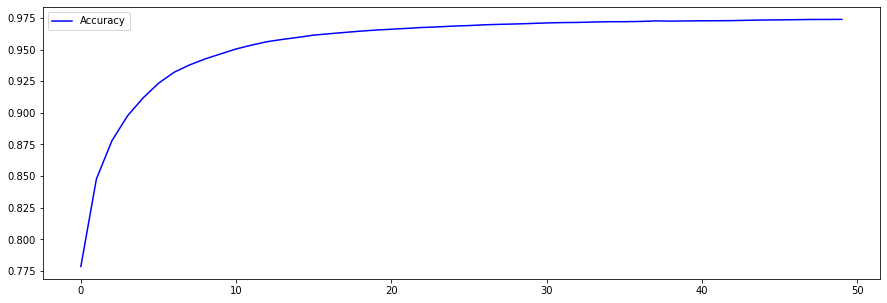

In [10]:
dat = pd.DataFrame({'a':np.array(accuracies)})
dat['epoch'] = np.arange(epochs)

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(dat['epoch'], dat['a'], color='blue', label='Accuracy')
ax.legend()

plt.savefig("/content/drive/My Drive/Colab Notebooks/acc_" + str(n) + "_" + str(n2) + "_" + str(c_mid) + ".png")

In [0]:

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'accuracies': accuracies,
            'epochs': epochs
            }, "/content/drive/My Drive/Colab Notebooks/model_" + str(n) + "_" + str(n2) + "_" + str(c_mid) + ".tar")

